In this Notebook, I will be doing EDA and train Entity recognition model on a tab separated text file.\
\
The basic assumption which I made during this work:
 - Sentences give more detail than individual words, So upon visual inspection of the text file, I found that whenever there is an empty line in the text file, that can be deemed as a line break, thus dividing the text file into ~3400 sentences.

Index of the Notebook
 - Import of relavant libraries


 - Exploratory Data Analysis
     - 1. Removing Null columns
     - 2. Visualising the Entity distribution
     - 3. What are those words in the Recognised Entities?(WordCloud)
     - 4. Most Frequent Entities
     - 5. Basic Text Cleaning and Topic Modelling
     - 6. Word Count Distribution in a Sentence without links and stopwords
     - 7. Character Count Distribution in a Sentence without links and stopwords
     - 8. Top 5 Positive & Negative Sentences and POS tagging
     - 9. Deeper Correlation Analysis into Text Sentences with links and stopwords
     - 10. Top Bigram
 
 
 - Entity Recognition problem
     - 1. Naive Approach (Submission -1 csv file )
     - 2. NER with Spacy (Submission -2 ner model)
     
I came up with the above two solutions and go with the second approach as its learning the model from the sentences, So basically its learning the pattern of sentences rather than the words directly which we have seen in Naive approach.
 
 
 - Evaluation metrics of the model

In [93]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

import plotly.express as px
from textblob import TextBlob
import re
import string

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 

from textwrap import wrap
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('averaged_perceptron_tagger')

from plotly.offline import init_notebook_mode, iplot 
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# preparing to train the model
import random
import plac
import warnings
from pathlib import Path
import spacy

import time
from spacy.util import minibatch, compounding



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
train_df=pd.read_csv('train.txt',delimiter="\t", header=None,names=["Word", "Entity_type"])

In [3]:
train_df.Entity_type.unique()

array(['O', 'B-location', 'I-location', nan, 'B-group', 'B-corporation',
       'B-person', 'B-creative-work', 'B-product', 'I-person',
       'I-creative-work', 'I-corporation', 'I-group', 'I-product'],
      dtype=object)

## EXPLORATORY DATA ANALYSIS

Exploratory Data Analysis is the process of exploring data, generating insights, testing hypotheses, checking assumptions and revealing underlying hidden patterns in the data.

<font color='blue'>***1. Removing Null columns- these are mainly formed due to extra empty lines in text file***</font>

In [4]:
len(train_df)

57893

In [5]:
train_df.isna().sum()

Word           2168
Entity_type    2162
dtype: int64

In [6]:
train_df.iloc[train_df[train_df.Word.isna()]["Entity_type"][train_df[train_df.Word.isna()]["Entity_type"].notna()].index]

,Word,Entity_type
55605,NaN,O
55606,NaN,O
55615,NaN,O
55616,NaN,O
56622,NaN,O
57688,NaN,O


We see that there are few Nan in word, but Entity type is not null. Since its not giving any information, We can discard it.

In [7]:
train_df.dropna(inplace=True)

In [8]:
len(train_df)

55725

<font color='blue'>***2. Visualising the Entity distribution***</font>

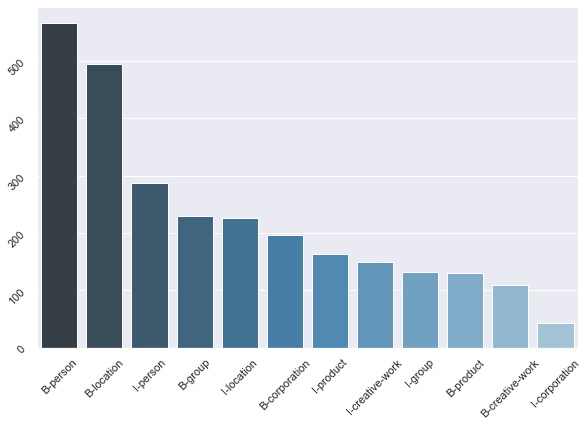

In [9]:
sns.set(rc={'figure.figsize':(9.7,6.27)})
g=sns.barplot(x=train_df[train_df["Entity_type"]!="O"]["Entity_type"].value_counts().index,\
            y=train_df[train_df["Entity_type"]!="O"]["Entity_type"].value_counts().values,\
           palette="Blues_d")
g.tick_params(labelrotation=45)

<font color='blue'>***3. What are those words in the Recognised Entities?***</font>

In [10]:
entity_types=list(train_df[train_df["Entity_type"]!="O"]["Entity_type"].value_counts().index)

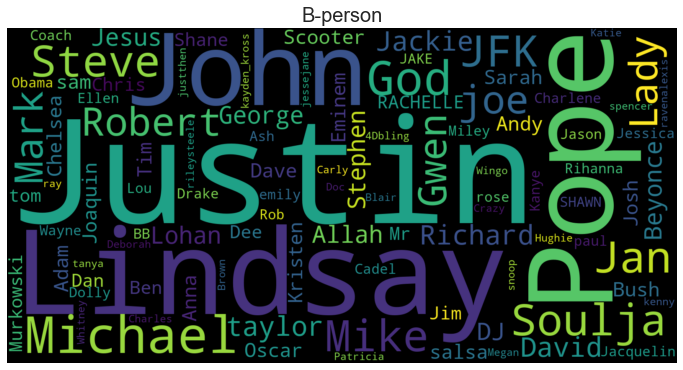

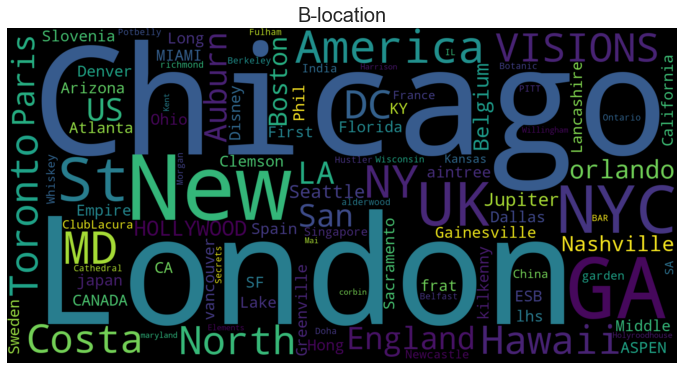

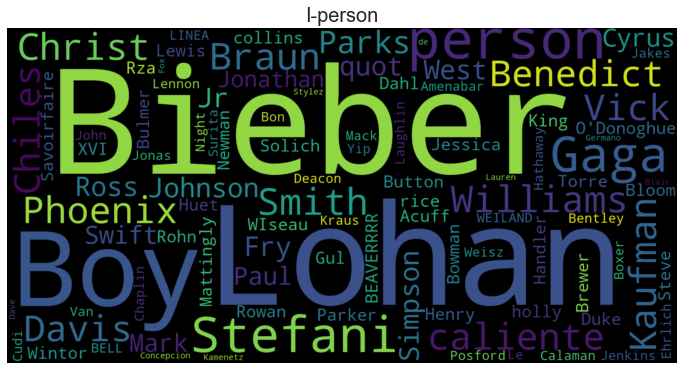

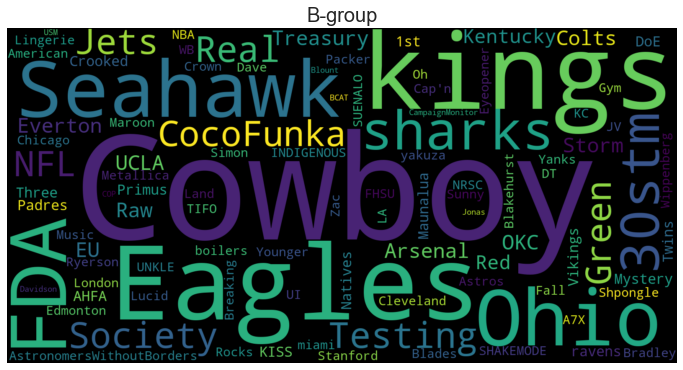

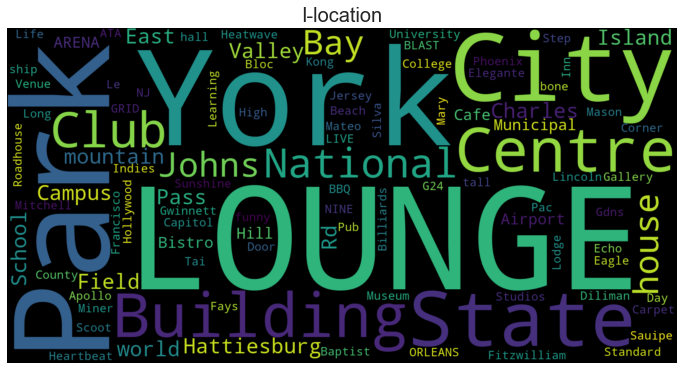

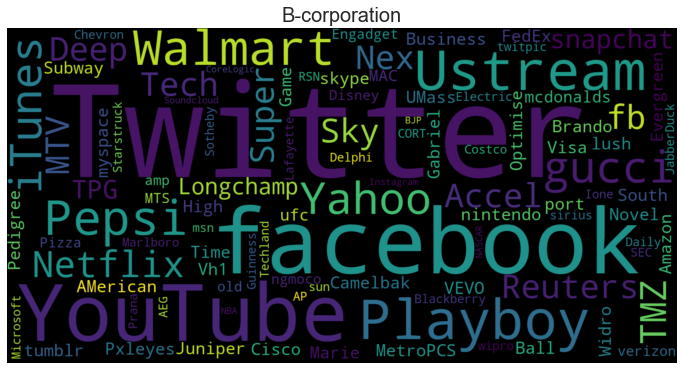

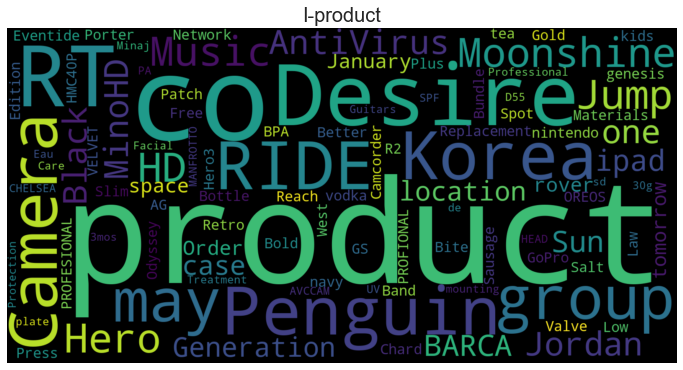

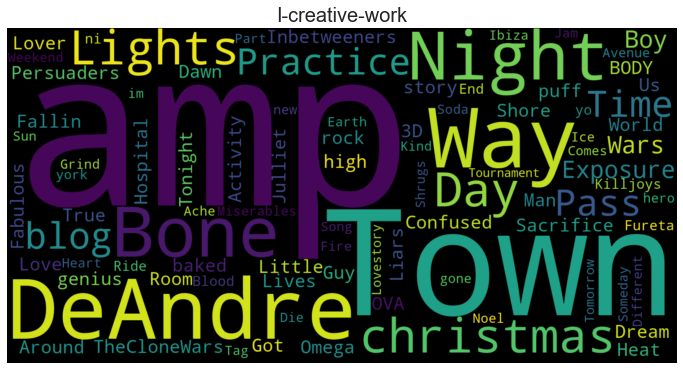

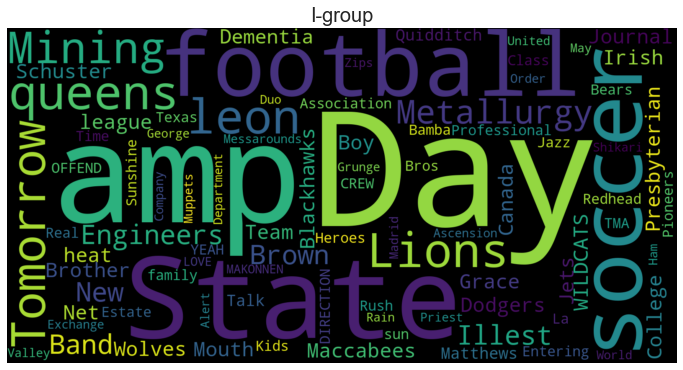

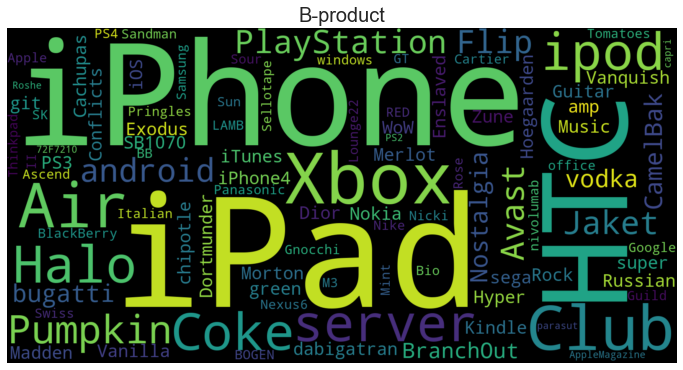

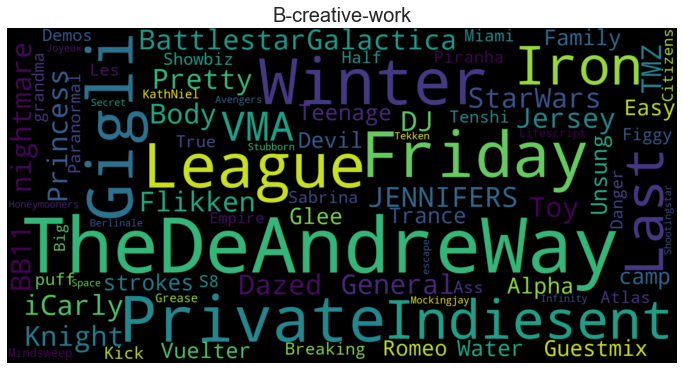

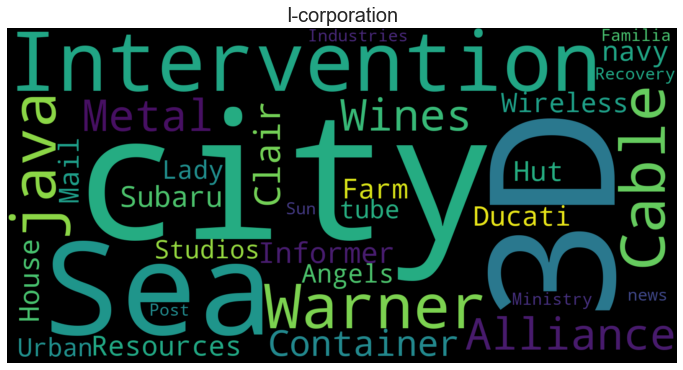

In [11]:
for interp in entity_types:
    text=" "
    text=" ".join(train_df[train_df["Entity_type"]==interp]["Word"].values)
    wordcloud = WordCloud(width=1600, height=800, 
                background_color="black", 
                stopwords = stopwords, max_words=100,
                min_font_size = 10).generate(text)
    
    plt.figure( figsize=(12,8) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title( interp,fontsize=20)
    plt.show()


<font color='blue'>***4. Most Frequent Entities***</font>

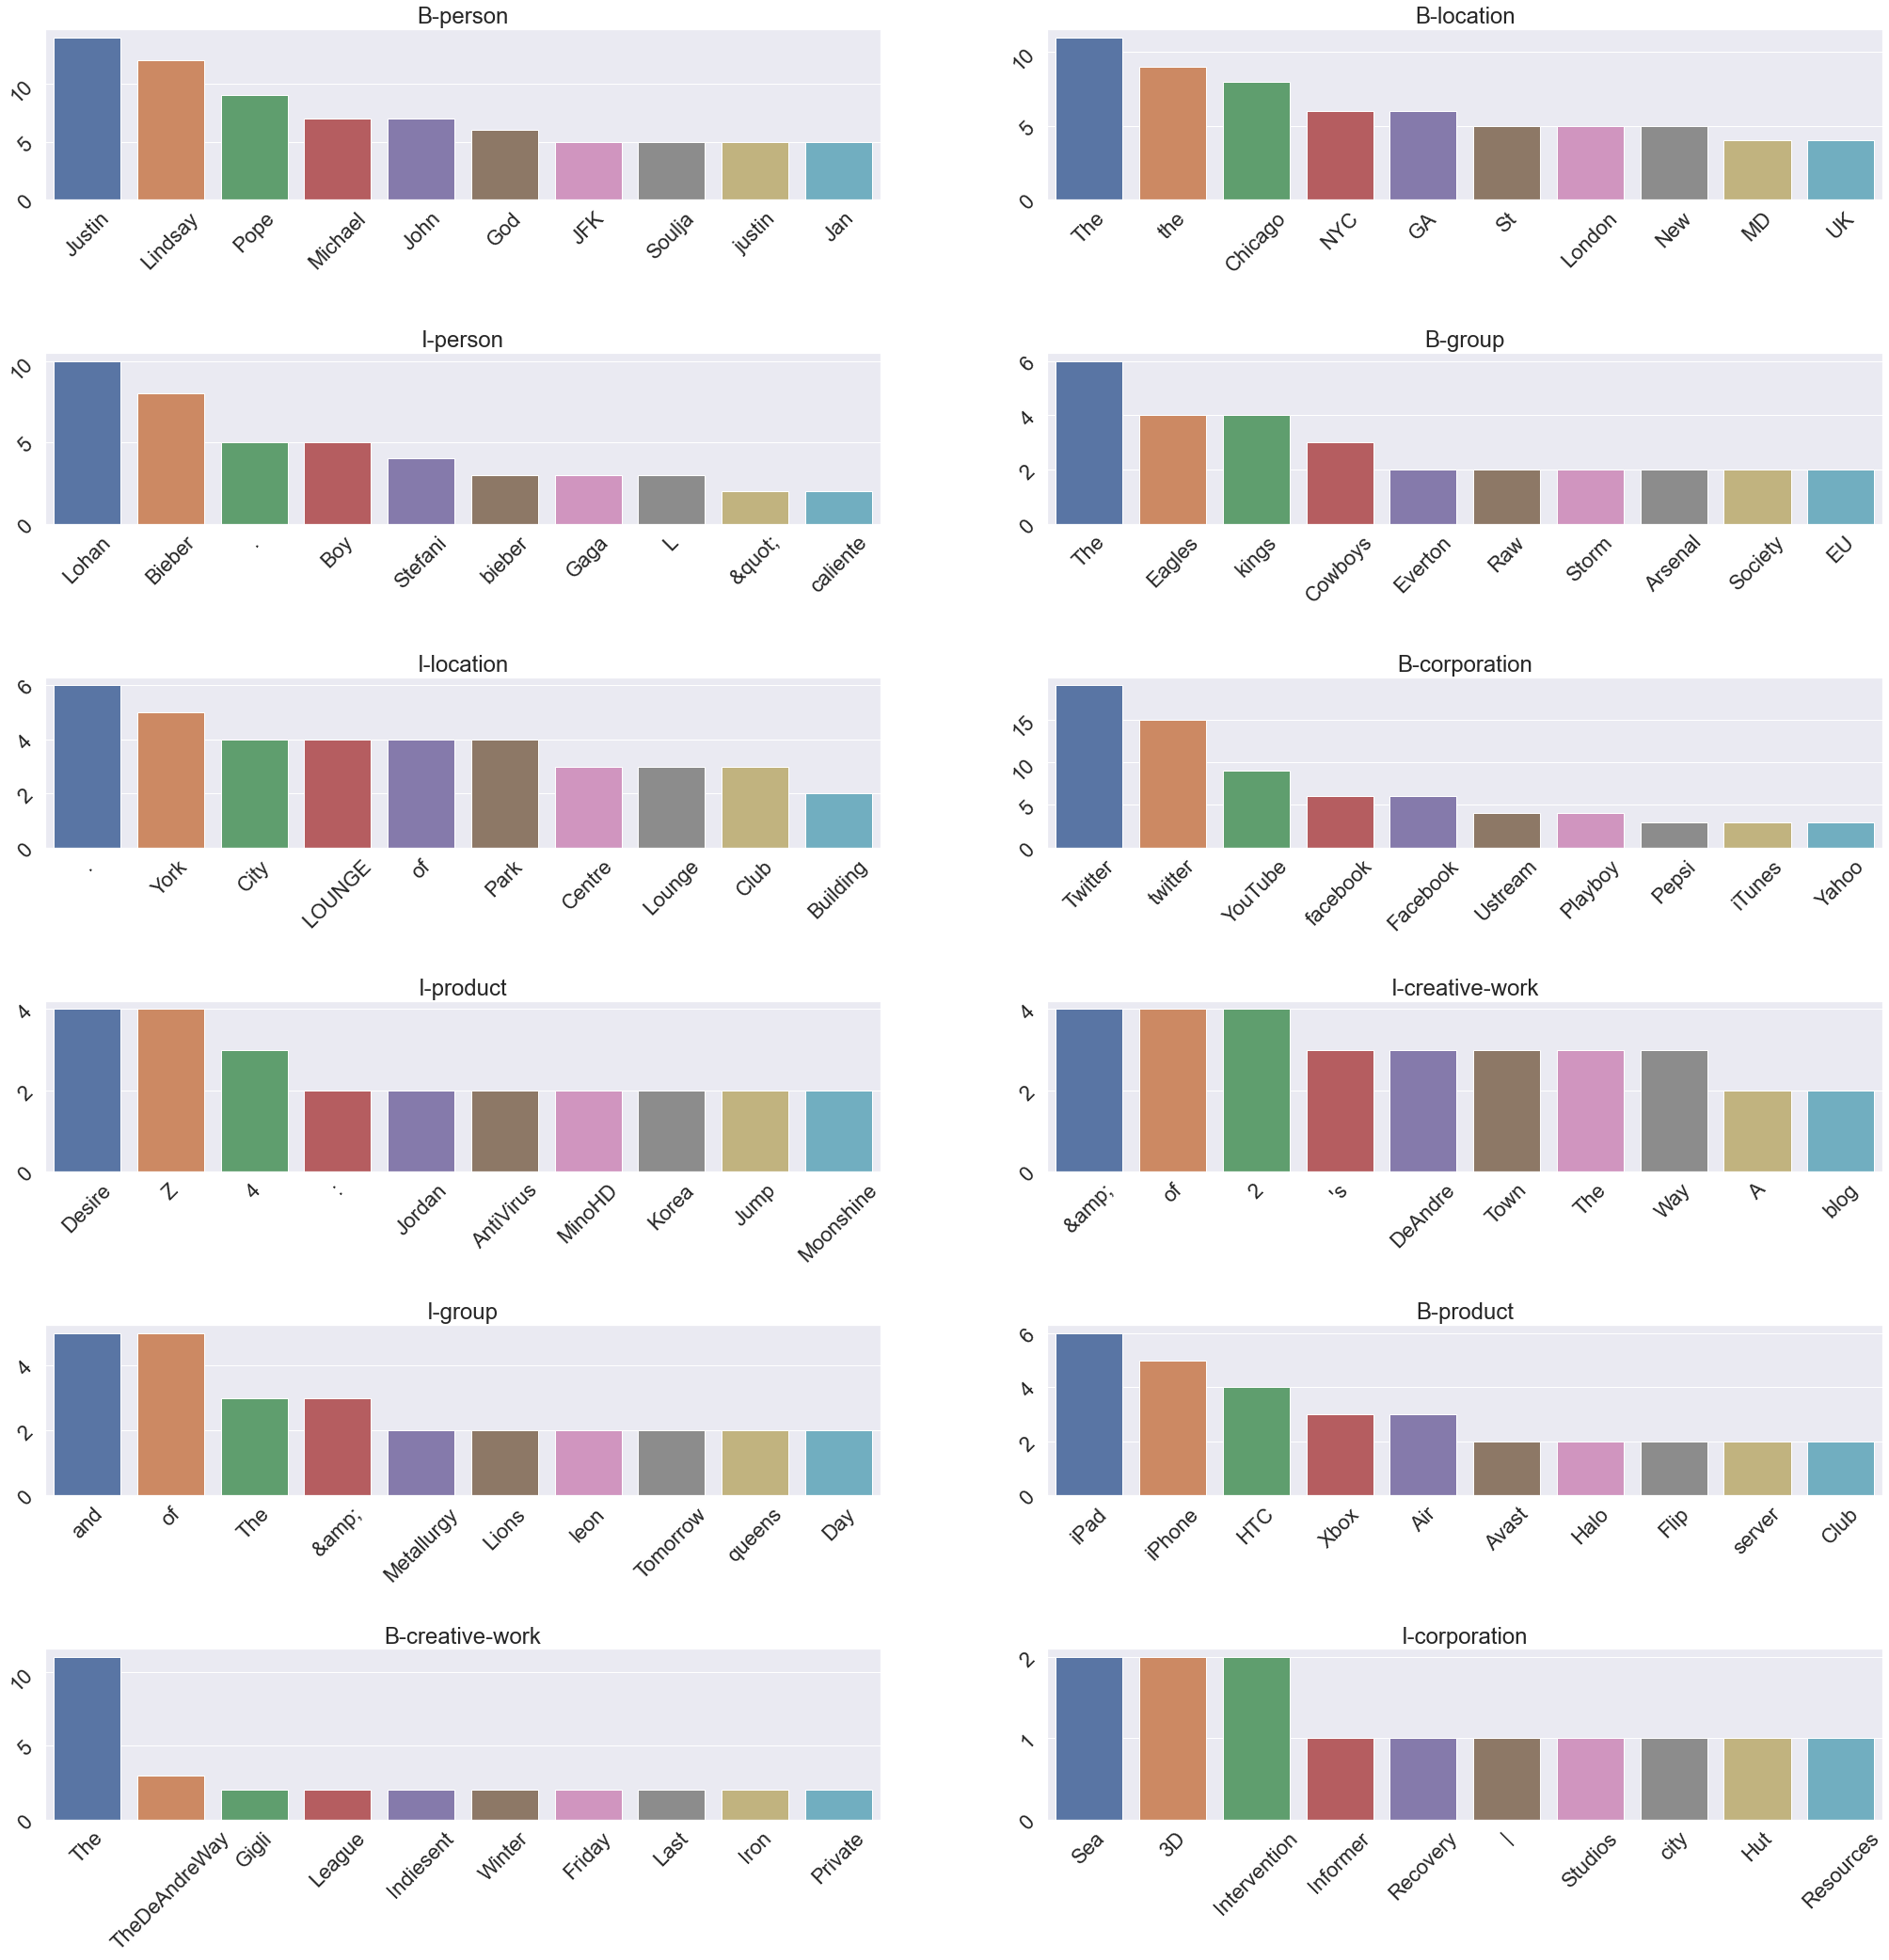

In [12]:
entity_types=list(train_df[train_df["Entity_type"]!="O"]["Entity_type"].value_counts().index)
sns.set(font_scale=2) 

fig, axes = plt.subplots(int(len(entity_types)/2), 2, figsize=(35, 35))
axes = axes.flatten()

for i,j in zip(entity_types,axes):
    sns.barplot(x=train_df[train_df["Entity_type"]==i]["Word"].value_counts()[:10].index,
           y=train_df[train_df["Entity_type"]==i]["Word"].value_counts()[:10].values,ax=j).set_title(i)
    j.set_title(i)
    j.tick_params(labelrotation=45)
plt.subplots_adjust(hspace = 0.9)
plt.show()

<font color='blue'>***5. Basic Text Cleaning and Topic Modelling***</font>

In [64]:
# We need the model to be in Sentences form to get Topic

f=open("train.txt", "r",  encoding="utf8")
train=f.readlines()

train_data_sentences = []
line = ''

for element in train:
    if len(element.strip('\n').split('\t'))!=2 or element.strip('\n').split('\t')[0]=='':

        train_data_sentences.append(line.lstrip())
       
        line = ''

    else: 
        
        word = element.strip('\n').split('\t')[0]
        if word[0] in string.punctuation and word[0]!="@":
            line += '' + word
        else:
            line += ' ' + word
    

In [65]:
len(train_data_sentences)

3395

In [66]:
train_data=pd.DataFrame(train_data_sentences,columns=["Sentences"])

In [67]:
train_data.head(5)

,Sentences
0,@paulwalk It's the view from where I'm living for two weeks. Empire State Building= ESB. Pretty bad storm here last evening.
1,From Green Newsfeed: AHFA extends deadline for Sage Award to Nov. 5 http://tinyurl.com/24agj38
2,Pxleyes Top 50 Photography Contest Pictures of August 2010... http://bit.ly/bgCyZ0#photography
3,today is my last day at the office.
4,"4Dbling's place til monday, party party party.&lt; 3"


In [68]:
def remove_hashtag_link(text):
    text  = " ".join([char for char in text.split(" ") if  not char.startswith("http") and not char.lower() in stopwords])
    return text

In [69]:
train_data['Sentences'] = train_data['Sentences'].apply(lambda x: remove_hashtag_link(x))

In [70]:
def remove_punct(text):
    text = " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    return text

In [71]:
train_data['Sentences'] = train_data['Sentences'].apply(lambda x: remove_punct(x))\
.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [72]:
train_data.head()

,Sentences
0,view living two weeks Empire State Building ESB Pretty bad storm last evening
1,Green Newsfeed AHFA extends deadline Sage Award Nov
2,Pxleyes Top Photography Contest Pictures August 2010
3,today last day office
4,4Dbling place til monday party party party


In [73]:
stopwords.update({'aren', 't','couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'will','may','now','mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn','see','come'})

In [74]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words=stopwords)
vz = vectorizer.fit_transform(train_data['Sentences'])

nmf = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(vz)

feature_names = vectorizer.get_feature_names()
no_top_words = 10
word_dict = {}

for topic_idx, topic in enumerate(nmf.components_[:10]):
    word_dict["Topic %d:"% (topic_idx)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

pd.DataFrame.from_dict(word_dict, orient='index')

,0,1,2,3,4,5,6,7,8,9
Topic 0:,day,today,good,happy,one,love,good day,read,one day,last day
Topic 1:,time,one,next time,next,first time,low,first,lol,amp,need
Topic 2:,tonight,going,game,game tonight,ready,good,amp,fun,look,going tonight
Topic 3:,january,2015,january 2015,jan,february 2015,jan 2015,february,weather,new,jam
Topic 4:,tomorrow,school,school tomorrow,night,excited,tomorrow night,work,gonna,got,class


Suggested_Topics:
- Topic 0: Mentions of good and a happy day
- Topic 1: Procrastination of work for the next time or experiencing something the first time
- Topic 2: Discussion about the game tonight
- Topic 3: Dry Weather in US in january 2015
- Topic 4: Excited feeling about getting back to school/work the next day

<font color='blue'>***6. Word Count Distribution in a Sentence without links and stopwords***</font>

In [75]:
train_data["Num_of_words"]=train_data["Sentences"].apply(lambda x: len([i for i in x.split()]))

In [76]:
fig = px.histogram(train_data, x="Num_of_words")
fig.update_layout(    autosize=False,    width=800,    height=400,)
fig.show()

From the above graph, it can be depicted that most of the sentences prefer writing headlines which contains about 5-12 words.
Very few sentences have exteremly high word counts

<font color='blue'>***7. Character Count Distribution in a Sentence without links and stopwords***</font>

In [77]:
train_data["Num_of_chars"]=train_data["Sentences"].apply(lambda x: len(x))

In [78]:
fig = px.histogram(train_data, x="Num_of_chars")
fig.update_layout(    autosize=False,    width=800,    height=400,)
fig.show()

From the above graph, it can be depicted that characters in sentence follow a failrly normal distribution

<font color='blue'>***8. Top 5 Positive & Negative Sentences and POS tagging***</font>

In [79]:
train_data["Polarity"]=train_data["Sentences"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [80]:
train_data.iloc[train_data.Polarity.nlargest(5).index]

,Sentences,Num_of_words,Num_of_chars,Polarity
53,know simply best Sept Issue boyfriend aunt worked Anna Wintor,10,61,1.0
63,got mine bbt aintree today Played table tennis store impressed analogue controller,12,82,1.0
219,Awesome day,2,11,1.0
269,days amazin DEF agree Boo best,6,30,1.0
341,weekend started today wonderful videos sharing wonderful,7,56,1.0


In [81]:
train_data.iloc[train_data.Polarity.nsmallest(5).index]

,Sentences,Num_of_words,Num_of_chars,Polarity
661,may nasty but works,4,19,-1.0
1324,horrible doctor featured Canada Team blog,6,41,-1.0
2390,Five Bullpens Stay Away MLB Odds think worst teams baseball think teams tha,13,75,-1.0
763,annoying tht ppl ask race ask name,7,34,-0.8
969,Man hate people carry ragedy luggage ima rip belt loader itaintmines,11,68,-0.8


In [82]:
fig = px.histogram(train_data, x="Polarity")
fig.update_layout(    autosize=False,    width=800,    height=400,)
fig.show()

Most Of the Sentences have neutral Polarity

In [94]:

blob = TextBlob(str(train_data["Sentences"]))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 10 Part-of-speech tagging for the train data')

NN noun, singular ‘desk’\
NNS noun plural ‘desks’\
NNP proper noun, singular ‘Harrison’\
CD cardinal digit\
JJ adjective ‘big’\
RB adverb very, silently,\
VBD verb, past tense took\
VBG verb, gerund/present participle taking\
VBN verb, past participle taken\
IN preposition/subordinating conjunction\
MD modal could, will\
PRP personal pronoun I, he, she\
JJS adjective, superlative ‘biggest’

<font color='blue'>***9. Deeper Correlation Analysis into Text Sentences with links and stopwords***</font>

In [32]:
#Nothing to be cleaned or changed from the sentence

df=pd.DataFrame(train_data_sentences,columns=["Sentences"])

In [33]:
df.head()

,Sentences
0,@paulwalk It's the view from where I'm living for two weeks. Empire State Building= ESB. Pretty bad storm here last evening.
1,From Green Newsfeed: AHFA extends deadline for Sage Award to Nov. 5 http://tinyurl.com/24agj38
2,Pxleyes Top 50 Photography Contest Pictures of August 2010... http://bit.ly/bgCyZ0#photography
3,today is my last day at the office.
4,"4Dbling's place til monday, party party party.&lt; 3"


In [34]:
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))
df["Num_of_words"]=df["Sentences"].apply(lambda x: len([i for i in x.split()]))
df["capitals"] = df["Sentences"].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df["char_count"] = df["Sentences"].apply(len)

df["caps_vs_length"] = df.apply(lambda row: float(row["capitals"])/(float(row["char_count"])+1),
axis=1)
df["num_exclamation_marks"] = df["Sentences"].apply(lambda comment: comment.count("!"))

df["num_question_marks"] = df["Sentences"].apply(lambda comment: comment.count("?"))

df["num_punctuation"] = df["Sentences"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df["num_stopwords"] = df["Sentences"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

df["has_http"] = df["Sentences"].apply(lambda x: count_regexp_occ(r'http[s]{0,1}://\S+', x))

In [35]:
df.head(5).T

,0,1,2,3,4
Sentences,@paulwalk It's the view from where I'm living for two weeks. Empire State Building= ESB. Pretty bad storm here last evening.,From Green Newsfeed: AHFA extends deadline for Sage Award to Nov. 5 http://tinyurl.com/24agj38,Pxleyes Top 50 Photography Contest Pictures of August 2010... http://bit.ly/bgCyZ0#photography,today is my last day at the office.,"4Dbling's place til monday, party party party.&lt; 3"
Num_of_words,21,13,10,8,8
capitals,9,10,8,0,1
char_count,124,94,94,35,52
caps_vs_length,0.072,0.105263,0.0842105,0,0.0188679
num_exclamation_marks,0,0,0,0,0
num_question_marks,0,0,0,0,0
num_punctuation,7,7,9,1,5
num_stopwords,7,3,1,4,0
has_http,0,1,1,0,0


In [36]:
cm = sns.light_palette("#2ecc71", as_cmap=True)
df.corr().style.background_gradient(cmap=cm,axis=1)

,Num_of_words,capitals,char_count,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_stopwords,has_http
Num_of_words,1.000000,0.150563,0.870049,-0.110615,0.020436,0.030274,0.228739,0.797027,-0.075634
capitals,0.150563,1.000000,0.273867,0.871982,0.079287,-0.000254,0.309534,-0.040242,0.240585
char_count,0.870049,0.273867,1.000000,-0.027063,0.021669,0.007879,0.554018,0.550140,0.246683
caps_vs_length,-0.110615,0.871982,-0.027063,1.000000,0.083349,-0.008076,0.137638,-0.197536,0.166542
num_exclamation_marks,0.020436,0.079287,0.021669,0.083349,1.000000,-0.005232,0.184028,-0.001395,-0.091011
num_question_marks,0.030274,-0.000254,0.007879,-0.008076,-0.005232,1.000000,0.036372,0.075457,-0.046891
num_punctuation,0.228739,0.309534,0.554018,0.137638,0.184028,0.036372,1.000000,-0.071024,0.614903
num_stopwords,0.797027,-0.040242,0.550140,-0.197536,-0.001395,0.075457,-0.071024,1.000000,-0.256924
has_http,-0.075634,0.240585,0.246683,0.166542,-0.091011,-0.046891,0.614903,-0.256924,1.000000


The highly correlated columns are char_count and Num_of_words, caps_vs_length and capitals, num_stopwords and Num_of_words

<font color='blue'>***10. Top Bigram***</font>

In [39]:
tfv = TfidfVectorizer(min_df=10,  max_features=20000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

X=tfv.fit_transform(train_data.Sentences)
features = np.array(tfv.get_feature_names())

Ngram_df = pd.DataFrame(
    {'Feature': list(features),
     'TFIDF_mean_score': list(np.mean(X.toarray(), axis=0))
    })

Ngram_df=Ngram_df.sort_values(by=["TFIDF_mean_score"],ascending=False)

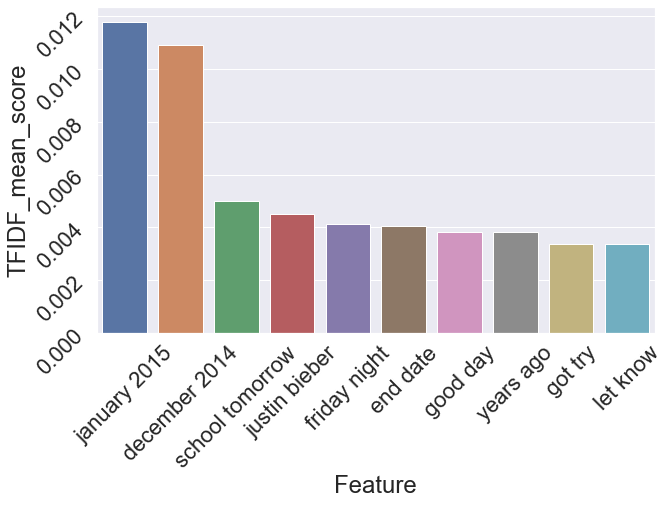

In [40]:
plt.figure(figsize=(10, 6))
g=sns.barplot(x="Feature",y="TFIDF_mean_score",data=Ngram_df[:10])
g.tick_params(labelrotation=45)

## ENTITY RECOGNITION PROBLEM

A named entity is a “real-world object” that’s assigned a name – for example, a person, a country, a product or a book title. 

Below is an example shown with spacy Package in Python

In [41]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


We will look into the below approaches

<font color='red'>***1.  Naive Approach- Creating a dictionary of values from train data and comparing them with the test set, (Comparing the similar words in test and train)***</font>

In [42]:
train_df1=train_df[train_df["Entity_type"]!="O"]

In [43]:
entity_dictionary=pd.Series(train_df1.Entity_type.values,index=train_df1.Word).to_dict()

In [44]:
# Checking on test data

f=open("test.txt", "r",encoding="utf8")
test=f.readlines()

test=pd.DataFrame(pd.DataFrame(test)[0].apply(lambda x : x.strip("\n")))

test.rename(columns={0: 'Word'},inplace=True)

test.head()

,Word
0,&
1,gt
2,;
3,*
4,The


In [45]:
# In train_data, stop_words and punctuation was also marked as entity, so removing all those in test data

test["Entity"]=test["Word"].apply(lambda x : entity_dictionary[x] \
                                  if (x in entity_dictionary.keys() and  \
                                      x.lower() not in stopwords and x not in string.punctuation \
                                      and len(x)>1 and x.isalpha()) else "O")

submission1 is the Dataframe with test predictions

In [46]:
submission1=test.copy()
test.head(5)

,Word,Entity
0,&,O
1,gt,O
2,;,O
3,*,O
4,The,O


In [47]:
len(test[test.Entity!="O"])

453

<font color='red'>***2.  Named entity recognition with SpaCy***</font>

SpaCy requires training data to be in the format of TRAIN_DATA = [(Sentence, {entities: [(start, end, label)]}, ...]. 

So, we have to transform our data to that format to train the model

APPO here is the basic shortcuts which are used in social media, we can clean the data little bit to improvise the model, but we should not delete punctuation or stopwords as they help train the model better.

In [49]:
APPO = {"aren't" : "are not", "can't" : "cannot","cant":"cannot","couldn't" : "could not","didn't" : "did not","doesn't" : "does not",
"don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","he'd" : "he would","he'll" : "he will",
"he's" : "he is","i'd" : "I would","i'd" : "I had","i'll" : "I will","i'm" : "I am","isn't" : "is not","It's" : "it is","it'll":"it will","i've" : "I have",
"let's" : "let us","mightn't" : "might not","mustn't" : "must not","shan't" : "shall not","she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not",
"that's" : "that is","there's" : "there is","they'd" : "they would","they'll" : "they will","they're" : "they are","they've" : "they have","we'd" : "we would","we're" : "we are","weren't" : "were not",
"we've" : "we have","what'll" : "what will","what're" : "what are","what's" : "what is","what've" : "what have","where's" : "where is",
"who'd" : "who would","who'll" : "who will","who're" : "who are","who's" : "who is","who've" : "who have","won't" : "will not","wouldn't" : "would not","you'd" : "you would",
"you'll" : "you will","you're" : "you are","you've" : "you have","'re": " are","wasn't": "was not","we'll":" will","didn't": "did not",
"tryin'":"trying","goin":"going","lil":"little","n't":"not","ive":"I have","it's":"it is","leavin":"leaving","dnt": "do not","tellin":"telling","getn":"getting","tryn":"trying"}

In [50]:
f=open("train.txt", "r")
train=f.readlines()

# format of TRAIN_DATA = [(Sentence, {entities: [(start, end, label)]}, ...]

train_data = []
line = ''
entity_list = []

for element in train:
    if len(element.strip('\n').split('\t'))!=2 or element.strip('\n').split('\t')[0]=='':
        char_entity_list = []
        line=' '.join([APPO.get(i.lower(), i) for i in line.split()])
        line=" ".join([i for i in line.split() if not i.startswith("http") and not i.startswith("@")])
        for word_entity in entity_list:
            start = line.lstrip().find(word_entity[0])
            char_entity_list.append((start, start+len(word_entity[0]), word_entity[1]))
        train_data.append((line.lstrip(), {"entities":char_entity_list}))
        line = ''
        entity_list = []
    else: 
        word = element.strip('\n').split('\t')[0]
        if word[0] in string.punctuation and word[0]!="@":
            line += '' + word
        else:
            line += ' ' + word
        if element.strip('\n').split('\t')[1] != 'O':
            entity_list.append((word, element.strip('\n').split('\t')[1]))

train_data is the required format

In [51]:
def train_spacy(train_data, labels, iterations, dropout = 0.2, display_freq = 2):
    ''' Train a spacy NER model, which can be queried against with test data
   
    train_data : training data in the format of (sentence, {entities: [(start, end, label)]})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
   
    # Add entity labels to the NER pipeline
    for i in labels:
        ner.add_label(i)

    # Disable other pipelines in SpaCy to only train NER
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        nlp.vocab.vectors.name = 'spacy_model' # without this, spaCy throws an "unnamed" error
        optimizer = nlp.begin_training()
        for itr in range(iterations):
            random.shuffle(train_data) # shuffle the training data before each iteration
            losses = {}
            batches = minibatch(train_data, size = compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(          
                    texts,
                    annotations,
                    drop = dropout,  
                    sgd = optimizer,
                    losses = losses)
            if itr % display_freq == 0:
                print("Iteration {} Loss: {}".format(itr + 1, losses))
    return nlp

In [52]:
ner = train_spacy(train_data, entity_types,15)

Iteration 1 Loss: {'ner': 265.5735244044748}
Iteration 3 Loss: {'ner': 126.50111367927049}
Iteration 5 Loss: {'ner': 72.1785063587366}
Iteration 7 Loss: {'ner': 49.60700558209824}
Iteration 9 Loss: {'ner': 35.93948685659888}
Iteration 11 Loss: {'ner': 30.073525048661256}
Iteration 13 Loss: {'ner': 27.75235769205968}
Iteration 15 Loss: {'ner': 20.29059433525342}


The below cell shows the glimpse from test_data

In [53]:
f=open("test.txt", "r",  encoding="utf8")
test=f.readlines()

test_data = []
line = ''

for element in test:
    if element.strip('\n')=='':

        test_data.append(line.lstrip())
       
        line = ''

    else: 
        word = element.strip('\n')
        line += ' ' + word

In [54]:
from spacy import displacy

for x in test_data[60:100]:
    doc = ner(x)
    displacy.render(doc, jupyter = True, style = "ent")

In [55]:
#submission2
ner

## EVALUATION METRICS


When you train a NER system the most typically evaluation method is to measure precision, recall and f1-score at a token level. 
Model performance is assessed on the entirety of the test dataset  based on the following metrics and their definitions.

- Precision: true positives / (true positives + false positives)
- Recall: true positives / (true positives + false negatives)
- F1-score: harmonic average of precision and recall

A true positive is an outcome where the model correctly predicts the positive class.\
Similarly, a true negative is an outcome where the model correctly predicts the negative class.

A false positive is an outcome where the model incorrectly predicts the positive class. \
And a false negative is an outcome where the model incorrectly predicts the negative class.

Precision is the percentage of named entities found by the learning system that are correct. \
Recall is the percentage of named entities present in the corpus that are found by the system

Here I would like to discuss few scenerios we can face while comparing the predictions versus the true values

1. Exact match between string and entity type match

| True String	|True Entity Type|	Predicted  String	|Predicted Entity Type|
| --- | --- | --- | --- |
| in	|O	|in	|O|
|New	|B-LOC	|New	| B-LOC|
|York	|I-LOC	|York	|I-LOC|
|.|	O	|.|	O|


            TP=2, FN=0, FP=0

2. Model hypothesized an entity

| True String	|True Entity Type|	Predicted  String	|Predicted Entity Type|
| --- | --- | --- | --- |
| in	|O	|in	|O|
|New	|B-LOC	|New	| B-LOC|
|York	|I-LOC	|York	|I-LOC|
|.|	O	|.|	I-LOC|


            TP=2, FN=0, FP=1

3. Model misses an entity

| True String	|True Entity Type|	Predicted  String	|Predicted Entity Type|
| --- | --- | --- | --- |
| in	|O	|in	|O|
|New	|B-LOC	|New	| O|
|York	|I-LOC	|York	|O|
|.|	O	|.|	O|

            TP=0, FN=2, FP=0

4. Model assigns the wrong entity type

| True String	|True Entity Type|	Predicted  String	|Predicted Entity Type|
| --- | --- | --- | --- |
| in	|O	|in	|O|
|New	|B-LOC	|New	| B-ORG|
|York	|I-LOC	|York	|I-ORG|
|.|	O	|.|	O|


            TP=0.5 * 2, FN=0, FP=0

5. Model gets the boundaries of the surface string wrong

| True String	|True Entity Type|	Predicted  String	|Predicted Entity Type|
| --- | --- | --- | --- |
| in	|O	|in	|O|
|New	|B-LOC	|New	| I-LOC|
|York	|I-LOC	|York	|I-LOC|
|.|	O	|.|	O|

            TP=1 + 0.5*1, FN=0, FP=0

In scenerios 1,2,3 we can directly get the false negative and false positive, but in scenerio 4 and 5, We cant ignore the partial accuracy of the model, In those cases while doing the confusion matrix we can add 0.5 instead of 0. Thus getting Precison and recall from TP, Fn and FP values.

## SUMMARY

Thus here we have seen EDA and two approaches to Entity Recognition model. We can also have a third approach using LSTM- Tensorflow, It is slightly complex and given the time frame, Could not complete it.